In [1]:
# Visualize Figure 1b
# Jackson M. Tsuji, 2023

In [2]:
import pandas as pd
from plotnine import *
from scipy.signal import find_peaks
from collections import namedtuple
from numpy import linspace

In [3]:
def load_hplc_pda_data(pda_filepath, pre_processed=False):

    if pre_processed is False:
        hplc_profile_data = pd.read_csv(pda_filepath, sep='\t', skiprows=[0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18], 
                                        encoding_errors='replace')\
          .rename(columns={'WAVE.TABLE':'Retention time (min)'})

    elif pre_processed is True:
        hplc_profile_data = pd.read_csv(pda_filepath, sep='\t')

    else:
        raise ValueError(f'pre_processed must be True or False, but you provided {pre_processed}')
    
    return(hplc_profile_data)

def tabulate_peaks(data_table, signal_col_name, ref_col_name, prominence):
    peak_pos, _ = find_peaks(data_table[signal_col_name].to_numpy(), prominence=prominence)
    peak_ref_values = data_table[ref_col_name][peak_pos]
    peak_heights = data_table[data_table[ref_col_name].isin(peak_ref_values)][signal_col_name]

    peak_table = pd.DataFrame({ref_col_name:peak_ref_values, signal_col_name:peak_heights})
    return(peak_table)

def tabulate_spectra(hplc_profile_data, retention_times, round_digits=None):
    spectra_data = hplc_profile_data[hplc_profile_data['Retention time (min)'].isin(retention_times)]\
      .set_index('Retention time (min)')\
      .transpose()\
      .reset_index()\
      .rename(columns={'index':'Wavelength (nm)'})\
      .melt(id_vars='Wavelength (nm)', value_name='Absorbance (A.U.)')
    
    spectra_data = spectra_data.astype({'Wavelength (nm)':'int64', 'Retention time (min)':'float64'})
    
    if round_digits is not None:
        spectra_data['Retention time (min)'] = spectra_data['Retention time (min)'].round(round_digits)
    
    return(spectra_data)

In [4]:
def process_hplc_data(pda_filepath, wavelength, provinence_profile=2000, provinence_spectrum=90000, pre_loaded_pda=False):
    wavelength = str(wavelength)
    
    # Load data
    if pre_loaded_pda is False:
        hplc_profile_data = load_hplc_pda_data(pda_filepath)
    else:
        hplc_profile_data = pda_filepath # assumes a pandas df of the correct format was passed in

    # Get peaks
    peaks = tabulate_peaks(hplc_profile_data, wavelength, 'Retention time (min)', provinence_profile)
    print('Identified ' + str(peaks.shape[0]) + ' peaks in HPLC profile at ' + wavelength + ' nm')
    
    profile_plot = (ggplot(hplc_profile_data, aes(x='Retention time (min)', y=wavelength))
              + geom_vline(xintercept=peaks['Retention time (min)'], linetype='dashed', colour='grey')
              + geom_path(size=0.8)
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank())
              + ylab('Absorbance at ' + wavelength + ' nm (A.U.)')
              )

    # Get associated spectra with peaks
    spectra = tabulate_spectra(hplc_profile_data, peaks['Retention time (min)'], round_digits=2)
    
    spectra_plot = (ggplot(spectra, aes(x='Wavelength (nm)', y='Absorbance (A.U.)'))
                   + geom_path()
                   + facet_grid('Retention time (min) ~ .', scales='free_y')
                   + theme_bw()
                   + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank())
                  )
    
    spectra_pre_plot = spectra.copy(deep=True)
    spectra_pre_plot['Retention time (min)'] = spectra_pre_plot['Retention time (min)'].astype('str')
    spectra_pre_plot['Retention time (min)'] = pd.Categorical(spectra_pre_plot['Retention time (min)'], 
                                                              categories=spectra_pre_plot['Retention time (min)'].unique(), ordered=True)

    spectra_overlay_plot = (ggplot(spectra_pre_plot, aes(x='Wavelength (nm)', y='Absorbance (A.U.)'))
                           + geom_path(aes(group='Retention time (min)', colour='Retention time (min)'), alpha=0.8, size=1)
                           + theme_bw()
                           + theme(text=element_text(colour='black', family='Arial'),
                              panel_grid=element_blank())
                          )
    
    # Get the spectrum associated with just the largest peak
    max_peak_rt = peaks[peaks[wavelength] == peaks[wavelength].max()]['Retention time (min)']
    spectra_max = tabulate_spectra(hplc_profile_data, max_peak_rt, round_digits=2)

    # Get absorbance peaks
    spectra_max_peaks = tabulate_peaks(spectra_max, 'Absorbance (A.U.)', 'Wavelength (nm)', provinence_spectrum)
    print('Identified ' + str(spectra_max_peaks.shape[0]) + ' peaks in largest profile absorbance spectrum at ' + str(round(list(max_peak_rt)[0],2)) + ' min')

    spectrum_max_plot = (ggplot(spectra_max, aes(x='Wavelength (nm)', y='Absorbance (A.U.)'))
                         + geom_vline(xintercept=spectra_max_peaks['Wavelength (nm)'], linetype='dashed', colour='grey')
                         + geom_path(size=0.8)
                         + theme_bw()
                         + theme(text=element_text(colour='black', family='Arial'),
                            panel_grid=element_blank())
                        )

    hplc_output = namedtuple('hplc_output', ['tables','figures'])
    table_output = namedtuple('table_output', ['profile','peaks','spectra','spectrum_max','spectrum_max_peaks'])
    figure_output = namedtuple('figure_output', ['profile', 'spectra_align', 'spectra_overlay', 'spectrum_max'])
    
    return(hplc_output(table_output(hplc_profile_data,peaks,spectra,spectra_max,spectra_max_peaks), 
                       figure_output(profile_plot, spectra_plot, spectra_overlay_plot, spectrum_max_plot)))

In [5]:
# Load
caur_raw = load_hplc_pda_data('https://zenodo.org/records/10275618/files/Cfx-aurantiacus-HPLC-run1.tsv.gz', pre_processed=True)
cferro_raw = load_hplc_pda_data('https://zenodo.org/records/10275618/files/Chl-ferrooxidans-HPLC-run1.tsv.gz', pre_processed=True)
chx_raw = load_hplc_pda_data('https://zenodo.org/records/10275618/files/Ca-Chx-allophototropha-L227-S17-HPLC-run1.tsv.gz', pre_processed=True)
caur_raw.head()

,Retention time (min),350,351,352,353,354,355,356,357,358,...,791,792,793,794,795,796,797,798,799,800
0,0.000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.032,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.043,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Identified 8 peaks in HPLC profile at 667 nm
Identified 2 peaks in largest profile absorbance spectrum at 35.77 min


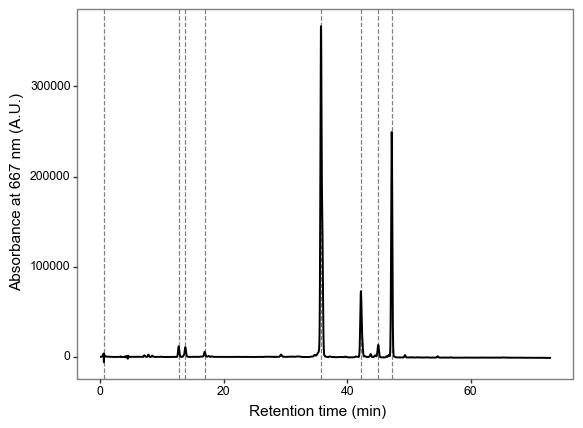

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

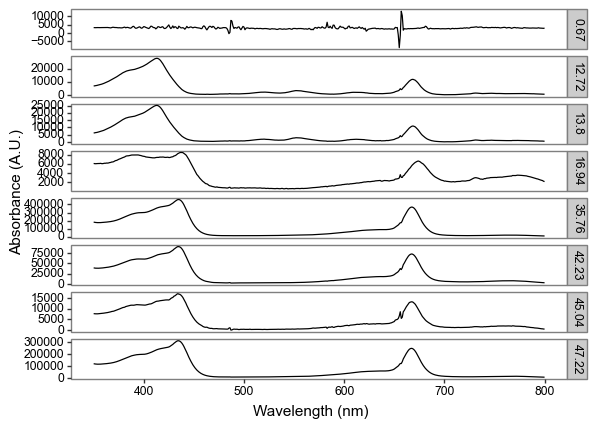

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


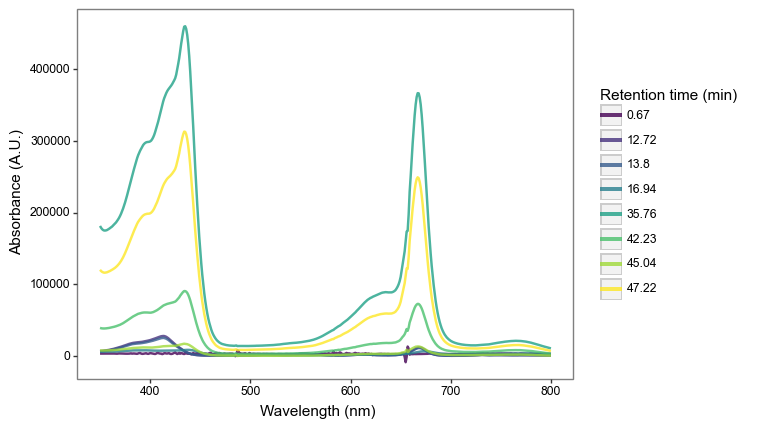

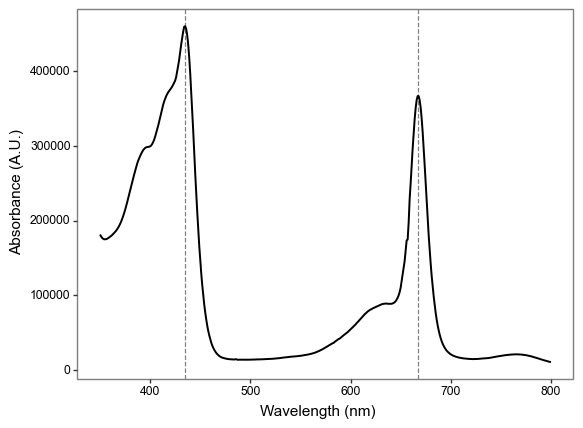

figure_output(profile=<ggplot: (385998666)>, spectra_align=<ggplot: (387923192)>, spectra_overlay=<ggplot: (387935939)>, spectrum_max=<ggplot: (387943224)>)

In [6]:
caur_processed = process_hplc_data(caur_raw, wavelength=667, provinence_profile=4000, 
                                   provinence_spectrum=90000, pre_loaded_pda=True)
caur_processed.figures

In [7]:
caur_processed.tables.peaks

,Retention time (min),667
63,0.672,2682
1193,12.725,11598
1294,13.803,10650
1588,16.939,5486
3353,35.765,366782
3959,42.229,72680
4222,45.035,13215
4427,47.221,249324


Identified 15 peaks in HPLC profile at 667 nm
Identified 2 peaks in largest profile absorbance spectrum at 31.1 min


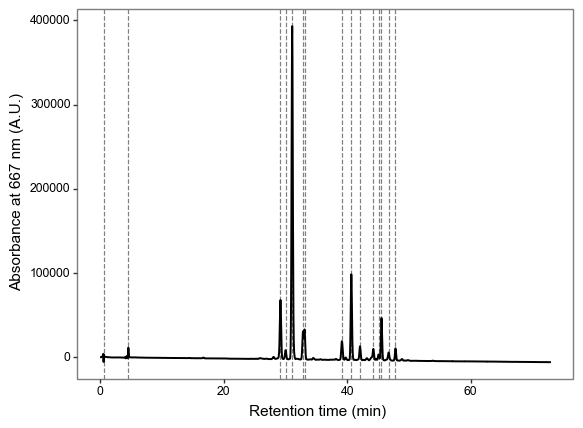

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

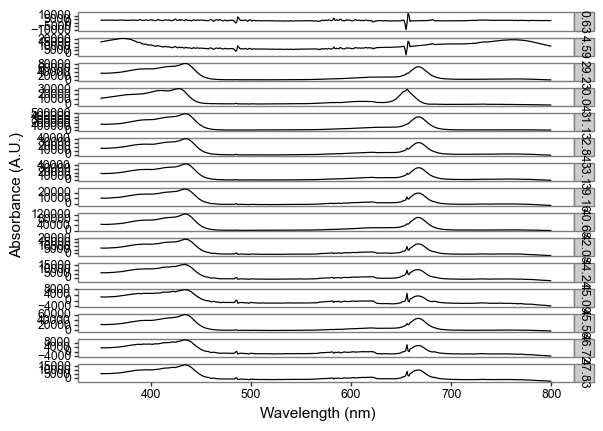

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


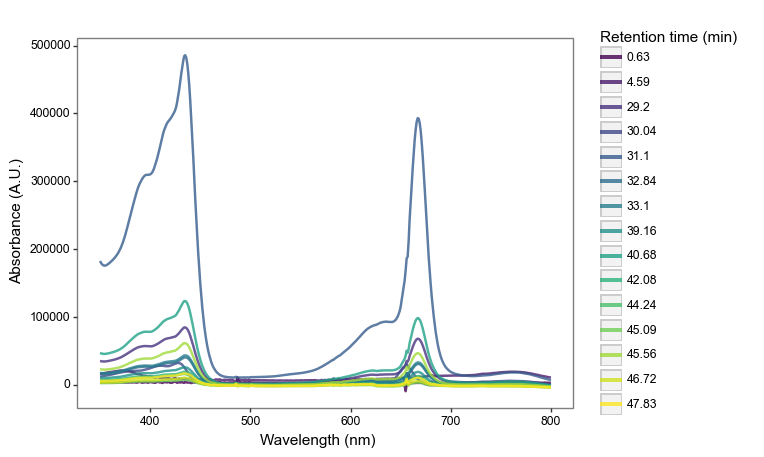

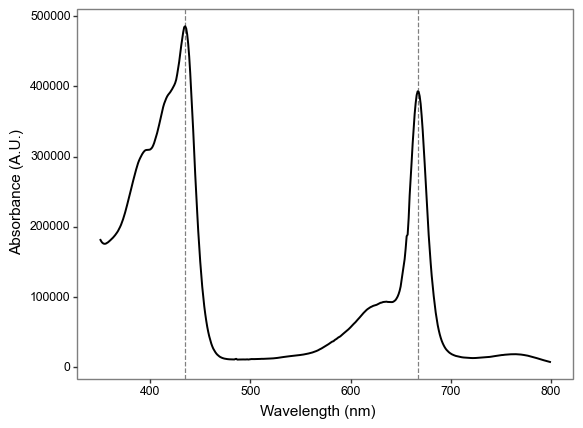

figure_output(profile=<ggplot: (388267874)>, spectra_align=<ggplot: (388382058)>, spectra_overlay=<ggplot: (388396727)>, spectrum_max=<ggplot: (388249653)>)

In [8]:
cferro_processed = process_hplc_data(cferro_raw, wavelength=667, provinence_profile=4000, 
                                     provinence_spectrum=90000, pre_loaded_pda=True)
cferro_processed.figures

In [9]:
cferro_processed.tables.peaks

,Retention time (min),667
59,0.629,2844
430,4.587,11314
2738,29.205,68000
2816,30.037,8400
2916,31.104,393115
3079,32.843,30684
3103,33.099,33018
3671,39.157,19042
3814,40.683,98407
3945,42.080,12986


Identified 12 peaks in HPLC profile at 667 nm
Identified 2 peaks in largest profile absorbance spectrum at 39.18 min


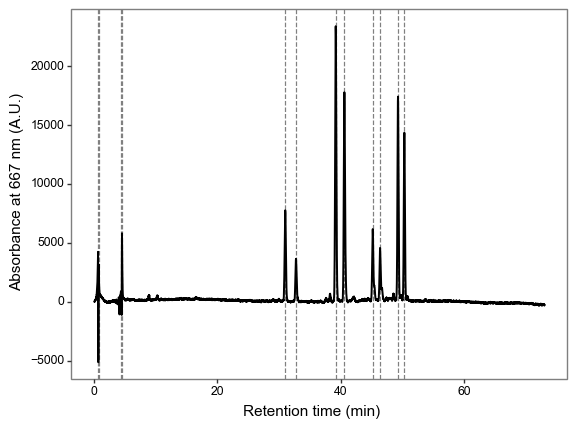

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:635: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

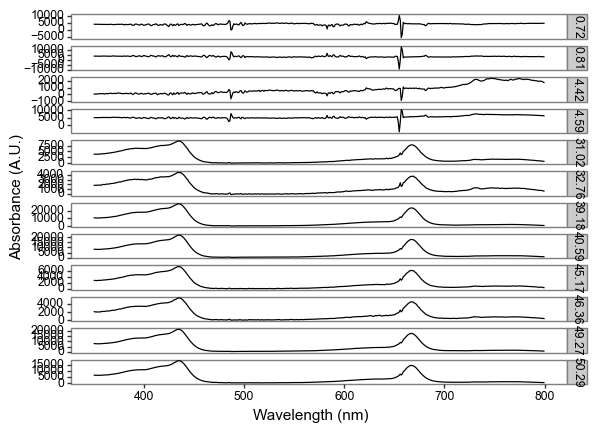

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


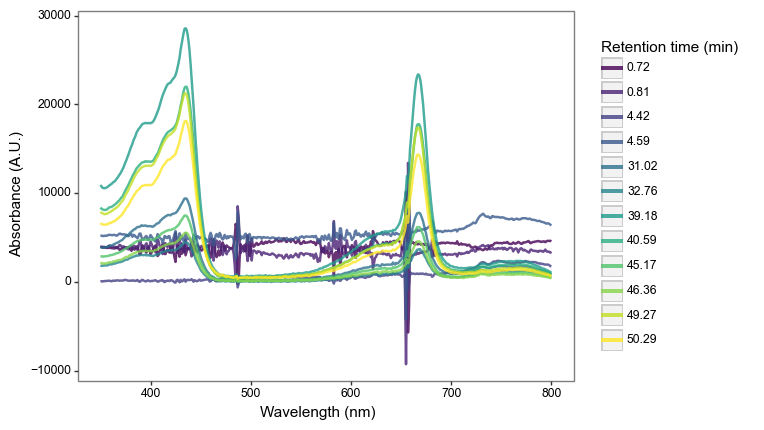

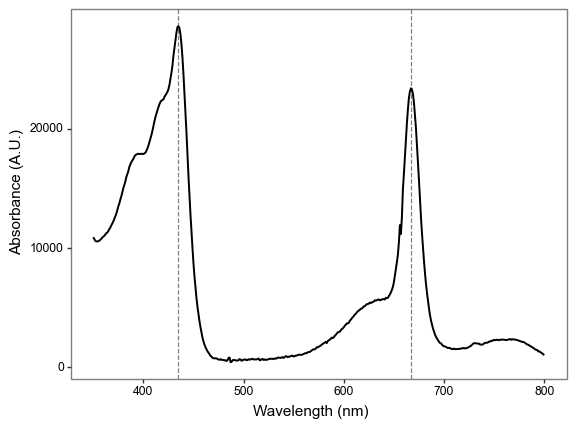

figure_output(profile=<ggplot: (387913690)>, spectra_align=<ggplot: (388871157)>, spectra_overlay=<ggplot: (388892346)>, spectrum_max=<ggplot: (388892289)>)

In [10]:
chx_processed = process_hplc_data(chx_raw, wavelength=667, provinence_profile=1000, 
                                  provinence_spectrum=10000, pre_loaded_pda=True)
chx_processed.figures

In [11]:
chx_processed.tables.peaks

,Retention time (min),667
67,0.715,4235
76,0.811,3154
414,4.416,883
430,4.587,5801
2908,31.019,7760
3071,32.757,3625
3673,39.179,23385
3805,40.587,17775
4235,45.173,6162
4346,46.357,4567


In [12]:
hplc_profiles_merged = caur_raw[['Retention time (min)', '667']].rename(columns={'667': 'Cfx. aurantiacus'})\
  .merge(cferro_raw[['Retention time (min)', '667']].rename(columns={'667': 'Chl. ferrooxidans'}), on='Retention time (min)', how='inner')\
  .merge(chx_raw[['Retention time (min)', '667']].rename(columns={'667': 'Ca. Chx. allophototropha'}), on='Retention time (min)', how='inner')

# Normalize based on max peak height
max1 = hplc_profiles_merged['Cfx. aurantiacus'].max()
max2 = hplc_profiles_merged['Chl. ferrooxidans'].max()
max3 = hplc_profiles_merged['Ca. Chx. allophototropha'].max()
hplc_profiles_merged['Chl. ferrooxidans'] = hplc_profiles_merged['Chl. ferrooxidans'] * max1 / max2
hplc_profiles_merged['Ca. Chx. allophototropha'] = hplc_profiles_merged['Ca. Chx. allophototropha'] * max1 / max3

# Offset
offset = max1 * 1.2
hplc_profiles_merged['Cfx. aurantiacus'] = hplc_profiles_merged['Cfx. aurantiacus'] + offset * 2
hplc_profiles_merged['Ca. Chx. allophototropha'] = hplc_profiles_merged['Ca. Chx. allophototropha'] + offset

hplc_profiles_merged = hplc_profiles_merged.melt(id_vars='Retention time (min)', var_name='Sample', value_name='Absorbance (A.U.)')

hplc_profiles_merged = hplc_profiles_merged[(hplc_profiles_merged['Retention time (min)'] > 25) & (hplc_profiles_merged['Retention time (min)'] < 55)]
hplc_profiles_merged['Sample'] = pd.Categorical(hplc_profiles_merged['Sample'], categories=['Cfx. aurantiacus', 'Ca. Chx. allophototropha', 'Chl. ferrooxidans'], ordered=True)

hplc_profiles_merged.head()

,Retention time (min),Sample,Absorbance (A.U.)
2344,25.003,Cfx. aurantiacus,880093.8
2345,25.013,Cfx. aurantiacus,880112.8
2346,25.024,Cfx. aurantiacus,880091.8
2347,25.035,Cfx. aurantiacus,880133.8
2348,25.045,Cfx. aurantiacus,880088.8


In [13]:
max_spectra = caur_processed.tables.spectrum_max.drop(columns='Retention time (min)').rename(columns={'Absorbance (A.U.)':'Cfx. aurantiacus'})\
  .merge(cferro_processed.tables.spectrum_max.drop(columns='Retention time (min)').rename(columns={'Absorbance (A.U.)':'Chl. ferrooxidans'}), on='Wavelength (nm)', how='inner')\
  .merge(chx_processed.tables.spectrum_max.drop(columns='Retention time (min)').rename(columns={'Absorbance (A.U.)':'Ca. Chx. allophototropha'}), on='Wavelength (nm)', how='inner')

# Normalize based on max peak height
max1 = max_spectra['Cfx. aurantiacus'].max()
max2 = max_spectra['Chl. ferrooxidans'].max()
max3 = max_spectra['Ca. Chx. allophototropha'].max()
max_spectra['Chl. ferrooxidans'] = max_spectra['Chl. ferrooxidans'] * max1 / max2
max_spectra['Ca. Chx. allophototropha'] = max_spectra['Ca. Chx. allophototropha'] * max1 / max3

# Offset
offset = max1 * 0.7
max_spectra['Cfx. aurantiacus'] = max_spectra['Cfx. aurantiacus'] + offset * 2
max_spectra['Ca. Chx. allophototropha'] = max_spectra['Ca. Chx. allophototropha'] + offset

max_spectra = max_spectra.melt(id_vars='Wavelength (nm)', var_name='Sample', value_name='Absorbance (A.U.)')
max_spectra['Sample'] = pd.Categorical(max_spectra['Sample'], categories=['Cfx. aurantiacus', 'Ca. Chx. allophototropha', 'Chl. ferrooxidans'], ordered=True)

max_spectra.head()

,Wavelength (nm),Sample,Absorbance (A.U.)
0,350,Cfx. aurantiacus,825746.0
1,351,Cfx. aurantiacus,823257.0
2,352,Cfx. aurantiacus,821346.0
3,353,Cfx. aurantiacus,820110.0
4,354,Cfx. aurantiacus,819418.0


/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


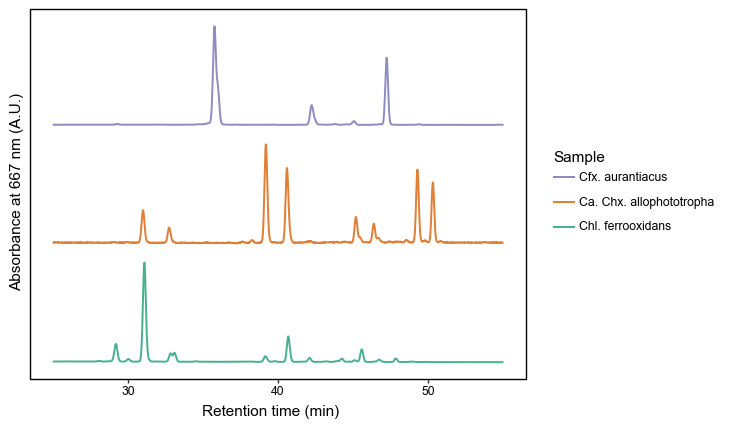

<ggplot: (388883839)>

In [14]:
profile_plot = (ggplot(hplc_profiles_merged, aes(x='Retention time (min)', y='Absorbance (A.U.)'))
              + geom_path(aes(group='Sample', colour='Sample'), alpha=0.8, size=0.8)
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank(),
                      axis_text_y=element_blank(),
                      axis_ticks_major_y=element_blank(),
                      legend_key=element_blank(),
                      panel_border=element_rect(colour='black'))
              + scale_colour_manual(values=['#7570b3', '#d95f02', '#1b9e77'])
              + ylab('Absorbance at 667 nm (A.U.)')
              )

profile_plot

In [15]:
profile_plot.save('HPLC_profiles_667nm.pdf', width=70, height=70, 
                  units='mm', verbose=False)

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


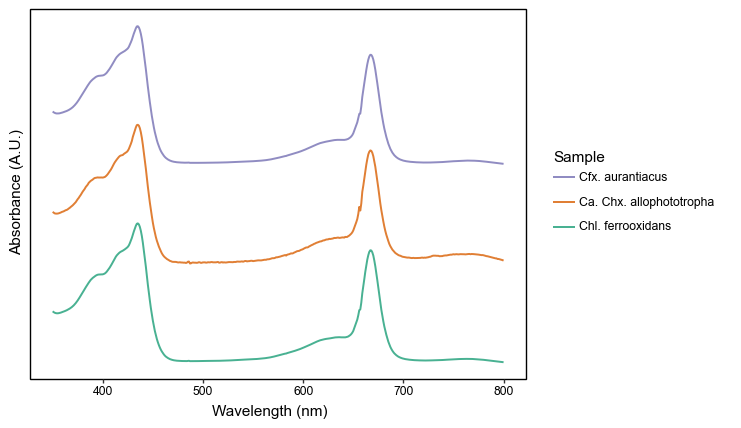

<ggplot: (388360482)>

In [16]:
spectra_plot = (ggplot(max_spectra, aes(x='Wavelength (nm)', y='Absorbance (A.U.)'))
              + geom_path(aes(group='Sample', colour='Sample'), alpha=0.8, size=0.8)
              + theme_bw()
              + theme(text=element_text(colour='black', family='Arial'),
                      panel_grid=element_blank(),
                      axis_text_y=element_blank(),
                      axis_ticks_major_y=element_blank(),
                      legend_key=element_blank(),
                      panel_border=element_rect(colour='black'))
              + scale_colour_manual(values=['#7570b3', '#d95f02', '#1b9e77'])
              )

spectra_plot

In [17]:
spectra_plot.save('HPLC_max_spectra_667nm.pdf', width=70, height=70, 
                  units='mm', verbose=False)

/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:1231: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/Users/jmtsuji/miniconda3/envs/jupyterlab/lib/python3.12/site-packages/plotnine/utils.py:317: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [18]:
caur_processed.tables.spectrum_max_peaks

,Wavelength (nm),Absorbance (A.U.)
85,435,460215
317,667,366782


In [19]:
cferro_processed.tables.spectrum_max_peaks

,Wavelength (nm),Absorbance (A.U.)
85,435,485911
317,667,393115


In [20]:
chx_processed.tables.spectrum_max_peaks

,Wavelength (nm),Absorbance (A.U.)
85,435,28589
317,667,23385
